In [1]:
from utils import *

In [2]:
# Config plotting:
mpl.rcParams['ps.useafm'] = True                                                     
mpl.rcParams['pdf.fonttype'] = 3

### Read schedule

In [3]:
# Initialize
schedule = toast.schedule.GroundSchedule()

The schedule is created in [Sec. 3](Sec3_Make_and_Analyze_schedule.ipynb) or imported from [pwg-tds/pipe-s0002/v6/schedules/schedule_sat.txt](https://github.com/simonsobs/pwg-scripts/blob/24a8c8202e2f80fb9b5097ee0e2dcfe5c1c07114/pwg-tds/pipe-s0002/v6/schedules/schedule_sat.txt). 

In [4]:
# Read
#schedule.read('schedules/schedule_sat_1day.txt') # generated with make_schedule.sh
#schedule.read('schedule_sat_pipe-s0002-v6.txt') # Full SAT schedule for 1 yr (74 observations)
schedule.read('schedules/split_schedule/schedule_029.txt') # Split schedule for 1 observation

TOAST INFO: Loading schedule from schedules/split_schedule/schedule_029.txt
TOAST INFO: Loaded 1 scans from schedules/split_schedule/schedule_029.txt totaling 19.9 minutes.


In [5]:
schedule

<GroundSchedule site=ATACAMA at -22.958 deg, -67.786 deg, 5200.0 m telescope SAT with 1 scans
  <GroundScan 'south' at 2025-07-01T13:39:03+00:00 with El = 55.0 deg, Az 138.1 deg -- 147.71 deg>
>

### Create focalplane

Here you can select the wafer slots, tube slots, and whether to thin the focal plane.

In [6]:
sample_rate = 32. #10. #Hz

In [7]:
focalplane = sotoast.SOFocalplane(
        hwfile=None,
        telescope='SAT1',
        sample_rate=sample_rate * u.Hz,
        bands='SAT_f090',
        wafer_slots='w25', 
        tube_slots=None,
        thinfp=None,
        comm=None,
    )

### Create telescope from focalplane and schedule

In [8]:
telescope = toast.Telescope(name="SAT1", 
                            focalplane=focalplane, 
                            site=toast.GroundSite("Atacama", schedule.site_lat,
                                            schedule.site_lon, schedule.site_alt))

### Create data object

In [9]:
data = toast.Data()

In [10]:
# This should be empty 
data 

<Data with 0 Observations:
Metadata:
{}
>

### Simulate a generic ground-based telescope scanning

This simulates ground-based pointing in constant elevation scans for a telescope located at a particular site and using a pre-created schedule. Here we include HWP.

In [11]:
_, sim_gnd = apply_scanning(data, telescope, schedule)

The data object will now contain (empty) observation instances, which otherwise can be uploaded from: 
- the context.yaml file (output of toast3 simulation, v4)
- the h5 file (output of toast3 simulation, v6)

In [12]:
# Inspect the data
#data.info

In [13]:
# Extract single instances from data.obs list, e.g.
#data.obs[0].telescope
for no, do in enumerate(data.obs):
    print(data.obs[no].telescope)

<Telescope 'SAT1': uid = 4101420846, site = <GroundSite 'Atacama' : uid = 2329977149, lon = -67.786 deg, lat = -22.957999999999995 deg, alt = 5199.999999999236 m, weather = <SimWeather : 'atacama', year = 2025, month = 5, hour = 13, site UID = 2329977149, realization = 0, median = False)>, focalplane = <Focalplane: 860 detectors, sample_rate = 32.0 Hz, FOV = 35.6 deg, detectors = [w25_p000_SAT_f090_A .. w25_p431_SAT_f090_B]>>


In [14]:
# Signal should be empty, check first detector
data.obs[0].detdata['signal'][0]

array([0., 0., 0., ..., 0., 0., 0.])

In [15]:
# Explore the data manager instance
data.obs[0].shared

<SharedDataManager
    times (column): shape=(38304,), dtype=float64
    position (column): shape=(38304, 3), dtype=float64
    velocity (column): shape=(38304, 3), dtype=float64
    azimuth (column): shape=(38304,), dtype=float64
    elevation (column): shape=(38304,), dtype=float64
    boresight_azel (column): shape=(38304, 4), dtype=float64
    boresight_radec (column): shape=(38304, 4), dtype=float64
    hwp_angle (column): shape=(38304,), dtype=float64
    flags (column): shape=(38304,), dtype=uint8>

In [16]:
'hwp_angle'

'hwp_angle'

Text(0, 0.5, 'Elevation')

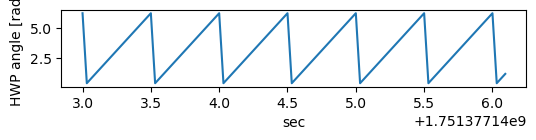

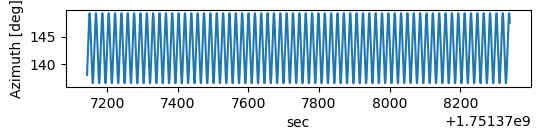

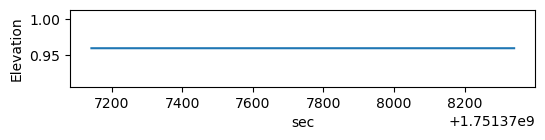

In [17]:
# Plot
fig,ax = plt.subplots(1,1,figsize=(6,1))
ax.plot(data.obs[0].shared['times'][:100], data.obs[0].shared['hwp_angle'][:100])
ax.set_xlabel('sec')
ax.set_ylabel('HWP angle [rad]')

fig,ax = plt.subplots(1,1,figsize=(6,1))
ax.plot(data.obs[0].shared['times'], np.array(data.obs[0].shared['azimuth'])*180./np.pi)
ax.set_xlabel('sec')
ax.set_ylabel('Azimuth [deg]')

fig,ax = plt.subplots(1,1,figsize=(6,1))
ax.plot(data.obs[0].shared['times'], data.obs[0].shared['elevation'])
ax.set_xlabel('sec')
ax.set_ylabel('Elevation')

### Pointing

In [18]:
data, det_pointing_radec = apply_det_pointing_radec(data, sim_gnd)
data, det_pointing_azel = apply_det_pointing_azel(data, sim_gnd)

Text(0, 0.5, 'azimuth [deg]')

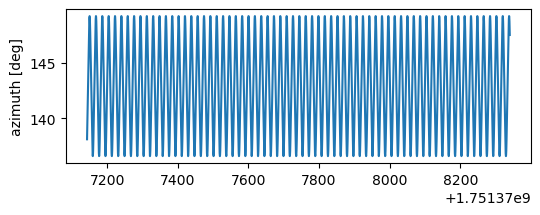

In [19]:
fig,ax = plt.subplots(1,1,figsize=(6,2))
ax.plot(data.obs[0].shared['times'], np.array(data.obs[0].shared['azimuth'])*180./np.pi)
ax.set_ylabel('azimuth [deg]')

### Pixel pointing healpix

In [21]:
nside_out = 64 

In [22]:
data, pixels_radec = apply_pixels_radec(data, det_pointing_radec, nside_out)

### Stokes Weights Radec

In [23]:
data, weights_radec = apply_weights_radec(data, det_pointing_radec)

### Add signal

Here we use as input the HEALPix format map that was generated in [Sec. 2](Sec2_Sky_maps.ipynb) and scan it to a detector timestream.

In [25]:
# Input map: signal only
file = f'input_maps/cmb_SAT_f093_ns{nside_out}.fits' #mine
#file = f'input_maps/reijo/cmb_SAT_f090.fits' #reijo's
IQUmap = hp.read_map(file, field=[0,1,2])

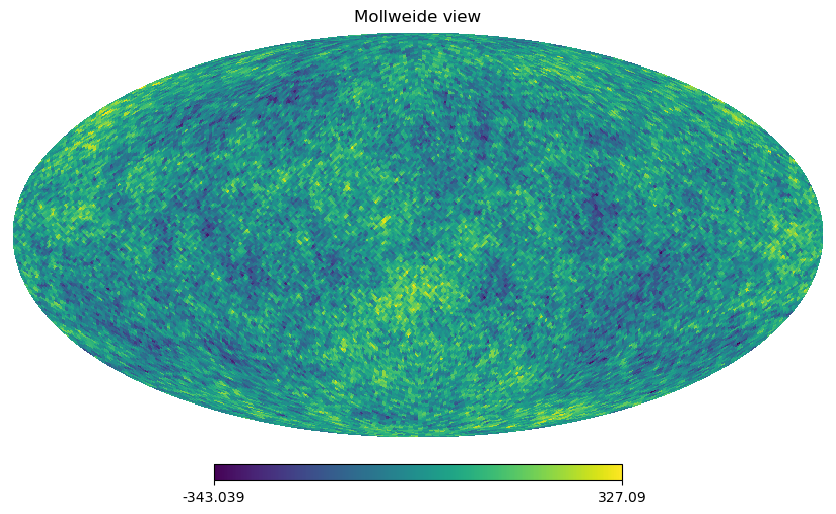

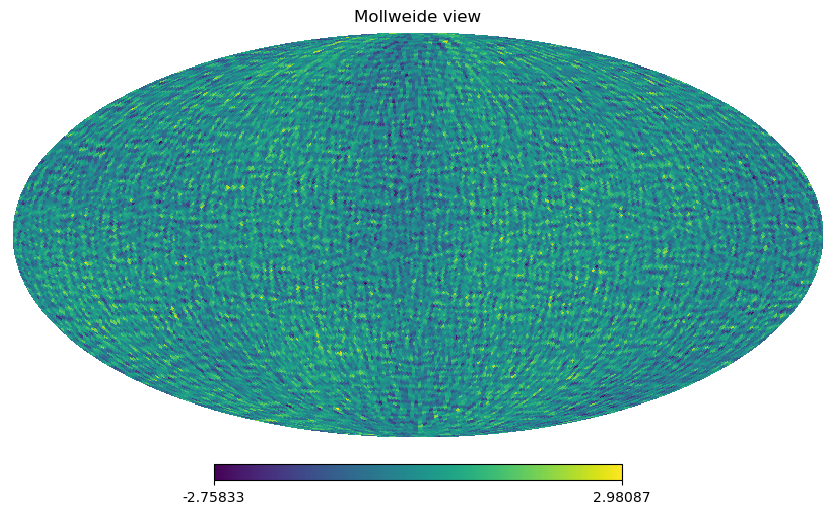

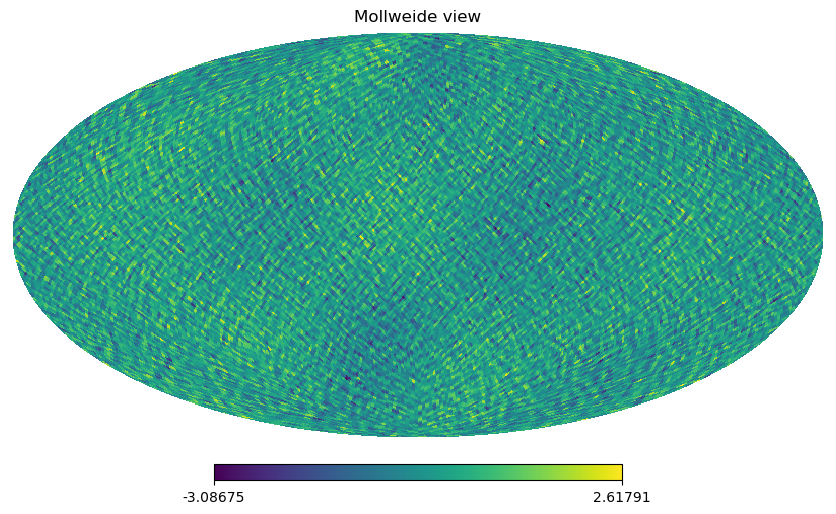

In [26]:
npol = 3
for p in np.arange(npol):
    hp.mollview(IQUmap[p])

TOAST INFO: Pixel data in input_maps/cmb_SAT_f093_ns64.fits does not have TUNIT1 key.  Assuming 'K'.


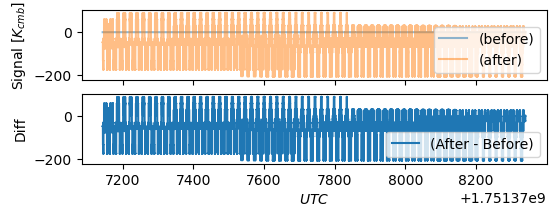

In [27]:
data, scan_map = apply_scan_map(data, file, pixels_radec, weights_radec)

### Add noise

In [28]:
_, noise_model = apply_noise_model(data)

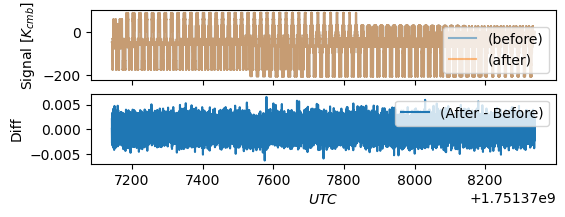

In [29]:
data, sim_noise = apply_sim_noise(data)

### Save HDF5

In [30]:
save_hdf5 = toast.ops.SaveHDF5(name="save_hdf5")
#hdf5_path = os.path.join('outputs', "hdf5")
hdf5_path = 'outputs'
#hdf5_path = 'outputs_reijo'
if not os.path.isdir(hdf5_path):
    os.makedirs(hdf5_path)
save_hdf5.volume = hdf5_path
save_hdf5.apply(data)

TOAST INFO: Wrote outputs/obs_south-0-29_1774499986.h5


In [31]:
# To load
import toast
import toast.io
# Manage MPI
# Take the global number of processes available (MPI.COMM_WORLD) 
# and divide them into groups. Each process group is assigned one or more observations. 
toast_comm = toast.Comm() #default: world=None, groupsize=0

In [32]:
ob = toast.io.load_hdf5(f'{hdf5_path}/obs_south-0-29_1774499986.h5', toast_comm)

In [33]:
# Inspect
ob

<Observation
  name = 'south-0-29'
  uid = '1774499986'  group has a single process (no MPI)
  telescope = <Telescope 'SAT1': uid = 4101420846, site = <GroundSite 'Atacama' : uid = 2329977149, lon = -67.786 deg, lat = -22.95799999999999 deg, alt = 5199.99999999924 m, weather = <SimWeather : 'atacama', year = 2025, month = 5, hour = 13, site UID = 2329977149, realization = 0, median = False)>, focalplane = <Focalplane: 860 detectors, sample_rate = 32.0 Hz, FOV = 35.6 deg, detectors = [w25_p000_SAT_f090_A .. w25_p431_SAT_f090_B]>>
  session = <Session 'south-0-29': uid = 1774499986, start = 2025-07-01 13:39:03+00:00, end = 2025-07-01 13:58:59.968750+00:00>
  noise_model = <AnalyticNoise model with 860 detectors>
  scan_el = 55.0 deg
  scan_max_az = 2.6045514105506706 rad
  scan_max_el = 0.9599310885968813 rad
  scan_min_az = 2.3837741245743227 rad
  scan_min_el = 0.9599310885968813 rad
  38304 total samples (38304 local)
  shared:  <SharedDataManager
    azimuth (column): shape=(38304,),

### Make it into context file

This can easily be read in AxisManager form, for pre-processing purposes.

In [35]:
import write_context

In [36]:
export_dirs = [f"{hdf5_path}/"]  # Directory to search for HDF data files
context_dir = f"{export_dirs[0]}"  #context_south-0-29"  # Change this to desired output context directory
if not os.path.isfile(f'{context_dir}context.yaml'):
    write_context.create_context(context_dir, export_dirs) #TODO: currently exportdir and contextdir

outputs/
Found 1 files in outputs/
Failed to load from cache file.
1
  added 1751377143_ST1_f090_1


In [37]:
#TODO: currently exportdir and contextdir need to match for Sec.5 to read h5 file

#### Continue to the next section

Go to [Section 5 - Pre-process the data and make maps](Sec5_Preprocess_TOD_Make_maps.ipynb).